# Predicting Flight Delays: Baseline Models (Linear Regression, Polynomial Regression, Random Forest, Gradient Boost)

In [221]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## 1. Data Cleaning

In [222]:
flights_df = pd.read_csv('../data/flights_data_merge.csv')

In [223]:
def extract_features_df(df):
    
    '''
    Extract relevant features from flight dataframe.
        Input: Raw dataframe
        Output: Dataframe with relevant features for analysis
    '''
    new_df = df[['fl_date', 'op_unique_carrier', 'origin', 'dest', 'crs_dep_time', 
                     'crs_arr_time', 'crs_elapsed_time', 'flights', 'distance', 'arr_delay']]
    
    new_df['fl_date'] = pd.to_datetime(new_df['fl_date'], format='%Y-%m-%d')
    new_df['is_arr_delay'] = new_df.apply(lambda row: 0 if row.arr_delay <= 0 else 1, axis=1)

    return new_df

In [224]:
features = extract_features_df(flights_df).rename(columns={'fl_date':'date'})

In [225]:
features.head()

,date,op_unique_carrier,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,flights,distance,arr_delay,is_arr_delay
0,2018-03-31,UA,EWR,FLL,1705,2017,192.0,1,1065,38.0,1
1,2018-11-27,DL,GEG,SLC,544,847,123.0,1,546,-10.0,0
2,2018-09-17,YV,DFW,VPS,1650,1846,116.0,1,641,47.0,1
3,2018-10-19,G4,ABE,MYR,1108,1239,91.0,1,518,654.0,1
4,2018-04-24,EV,CLE,LGA,912,1048,96.0,1,419,-8.0,0


In [226]:
origin_flights = features.groupby(['date', 'origin']).size().reset_index().rename(columns={0:'num_dep_flights'})

In [227]:
arrival_flights = features.groupby(['date', 'dest']).size().reset_index().rename(columns={0:'num_arr_flights'})

In [228]:
features = pd.merge(features, origin_flights, on=['date', 'origin'], how='inner')

In [229]:
features = pd.merge(features, arrival_flights, on=['date', 'dest'], how='inner')

In [230]:
features.dropna(inplace=True)

In [231]:
le = LabelEncoder()
features['op_unique_carrier'] = le.fit_transform(features['op_unique_carrier'])

In [232]:
le = LabelEncoder()
features['origin'] = le.fit_transform(features['origin'])

In [233]:
le = LabelEncoder()
features['dest'] = le.fit_transform(features['dest'])

In [234]:
features.isna().any()

date                 False
op_unique_carrier    False
origin               False
dest                 False
crs_dep_time         False
crs_arr_time         False
crs_elapsed_time     False
flights              False
distance             False
arr_delay            False
is_arr_delay         False
num_dep_flights      False
num_arr_flights      False
dtype: bool

In [235]:
features.head()
features.drop('date', axis=1, inplace=True)

In [236]:
features.head()

,op_unique_carrier,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,flights,distance,arr_delay,is_arr_delay,num_dep_flights,num_arr_flights
0,22,119,127,1705,2017,192.0,1,1065,38.0,1,27,16
1,5,119,127,1547,1856,189.0,1,1065,-14.0,0,27,16
2,5,47,127,1855,2220,205.0,1,1237,-13.0,0,23,16
3,24,291,127,1515,1830,195.0,1,1188,-7.0,0,8,16
4,5,185,127,600,903,183.0,1,1069,7.0,1,19,16


In [237]:
len(features)

980521

In [238]:
#Randomly select 10,000 rows for model building
data = features.sample(frac=1)[:10000]
data.head()

,op_unique_carrier,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,flights,distance,arr_delay,is_arr_delay,num_dep_flights,num_arr_flights
919669,19,29,103,810,922,72.0,1,113,-22.0,0,1,25
478160,26,271,228,2045,2207,82.0,1,289,-7.0,0,24,2
138752,2,74,93,920,1045,85.0,1,331,-13.0,0,45,36
875153,16,44,257,1013,1110,57.0,1,116,200.0,1,2,63
860120,8,243,93,2015,2343,148.0,1,931,-5.0,0,39,31


<AxesSubplot:>

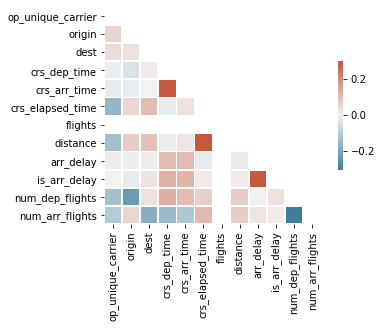

In [239]:
corr = data.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask,cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [240]:
data.drop(['flights', 'num_dep_flights', 'num_arr_flights'], axis=1, inplace=True)

In [241]:
data.var(axis=0)

op_unique_carrier        73.199528
origin                10349.995216
dest                  10101.936586
crs_dep_time         243028.234476
crs_arr_time         273716.196327
crs_elapsed_time       5030.382987
distance             332298.189124
arr_delay              2375.440123
is_arr_delay              0.226614
dtype: float64

In [242]:
X = data.drop(['arr_delay', 'is_arr_delay'], axis=1).to_numpy()
y_class = data['is_arr_delay'].to_numpy()
y_reg = data['arr_delay'].to_numpy()

## 2. Functions

In [280]:
def scale_data(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data)

def linear_model(type, x_train, y_train, x_test, hyperparams={}):

    if type.lower() == 'linear':
        model = LinearRegression(**hyperparams)
    elif type.lower() == 'ridge':
        model = Ridge(**hyperparams)
    elif type.lower() == 'lasso':
        model = Lasso(**hyperparams)
    elif type.lower() == 'polynomial':
        polyreg = PolynomialFeatures(**hyperparams)
        x_train = polyreg.fit_transform(x_train)
        model = LinearRegression()
        
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    return model.coef_, y_pred

def polynomial_regression(x, y, hyperparams={}):
    polyreg = PolynomialFeatures(**hyperparams)
    x = polyreg.fit_transform(x)

    X = scale_data(x)
    y = scale_data(y.reshape(-1,1))

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    
    score = evaluate_regression(y_test, y_pred)

    return linreg.coef_, y_pred, score

def random_forest(type, x_train, y_train, x_test, hyperparams={}):

    if type.lower() == 'classification':
        model = RandomForestClassifier(**hyperparams)
    elif type.lower() == 'regression':
        model = RandomForestRegressor(**hyperparams)
    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    return y_pred

def gradient_boost(type, x_train, y_train, x_test, hyperparams={}):

    if type.lower() == 'classification':
        model = GradientBoostingClassifier(**hyperparams)
    elif type.lower() == 'regression':
        model = GradientBoostingRegressor(**hyperparams)
    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    return y_pred

def evaluate_binary_classification(model_name, y_test, y_pred):

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1_score = recall_score(y_test, y_pred)
    rocauc_score = roc_auc_score(y_test, y_pred)

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True)
    plt.tight_layout()
    plt.title(f'{model_name}', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    return accuracy, precision, recall, f1_score, rocauc_score

def evaluate_regression(y_test, y_pred):

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mae, mse, r2

## 5. Regression Models

In [244]:
X_scaled = scale_data(X)
y_reg_scaled = scale_data(y_reg.reshape(-1,1))

In [245]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_reg_scaled, train_size=0.75)

### 5.1 Linear Regression

In [246]:
y_lin_coeffs, y_lin_pred = linear_model('linear', X_train, y_train, X_test)

In [247]:
mae_lin, mse_lin, r2_lin = evaluate_regression(y_test, y_lin_pred)

In [248]:
print(mae_lin, mse_lin, r2_lin)

0.5267371505038996 1.1957305036151857 0.010242422033119869


### 5.2 Ridge Regression

In [249]:
y_ridge_coeffs, y_ridge_pred = linear_model('ridge', X_train, y_train, X_test, {'alpha': 0.5})

In [250]:
mae_ridge, mse_ridge, r2_ridge = evaluate_regression(y_test, y_ridge_pred)

In [251]:
print(mae_ridge, mse_ridge, r2_ridge)

0.5267364506535088 1.195731207405871 0.010241839475292558


### 5.3 Lasso Regression

In [252]:
y_lasso_coeffs, y_lasso_pred = linear_model('lasso', X_train, y_train, X_test, {'alpha':0.5})

In [253]:
mae_lasso, mse_lasso, r2_lasso = evaluate_regression(y_test, y_lasso_pred)

In [254]:
print(mae_lasso, mse_lasso, r2_lasso )

0.5314159540963483 1.2097558621916622 -0.0013669706291901118


### 5.4 Polynomial Regression

In [255]:
poly_coeffs, y_poly_pred, score = polynomial_regression(X, y_reg, {'degree': 3})

In [256]:
print(score)

(0.5047753370980343, 0.9139089195971064, -0.0016893053402011748)


### 5.5 Random Forest Regressor

In [260]:
y_pred_rfr = random_forest('regression', X_train, y_train, X_test) 

In [261]:
mae_rfr, mse_rfr, r2_rfr = evaluate_regression(y_test, y_pred_rfr)

In [262]:
print(mae_rfr, mse_rfr, r2_rfr )

0.5682595421752759 1.2433373985741314 -0.029163852964991133


### 5.6 Gradient Boost Regressor

In [263]:
y_pred_grad = gradient_boost('regression', X_train, y_train, X_test)

In [264]:
mae_gbr, mse_gbr, r2_gbr = evaluate_regression(y_test, y_pred_grad)

In [265]:
print(mae_gbr, mse_gbr, r2_gbr)

0.5285470128817559 1.208847282821328 -0.0006149003974331713


## 6. Classification

In [275]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_class, train_size=0.75, stratify=y_class)

### 6.1 Random Forest Classifier

In [276]:
y_pred_rfc = random_forest('classification', X_train, y_train, X_test)

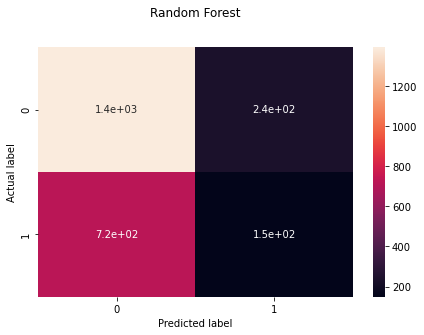

In [277]:
accuracy_rfc, precision_rfc, recall_rfc, f1_score_rfc, rocauc_score_rfc = evaluate_binary_classification('Random Forest', y_test, y_pred_rfc)

### 6.2 Gradient Boost Classifier 

In [278]:
y_pred_gbc = gradient_boost('classification', X_train, y_train, X_test)

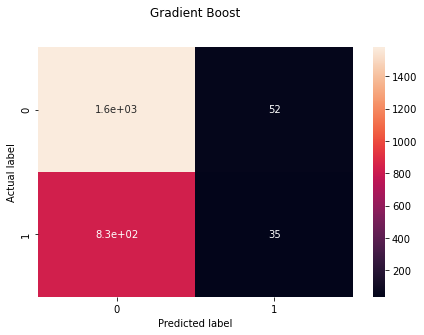

In [279]:
accuracy_gbc, precision_gbc, recall_gbc, f1_score_gbc, rocauc_score_gbc = evaluate_binary_classification('Gradient Boost', y_test, y_pred_gbc)